In [132]:
import pandas as pd
from pathlib import Path
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime
import re
from scipy import stats
import numpy as np
import statsmodels.api as sm
from matplotlib import colormaps
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm


from mri_data import file_manager as fm

In [133]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
work_home = drive_root / "srs-9/longitudinal"
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
date_format = "%Y%m%d"
fig_path = Path("/home/srs-9/Projects/ms_mri/choroid_thalamus_project/figures")

choroid_volumes = pd.read_csv("/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv",
                              index_col="subid").dropna()

thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv("/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", 
                              index_col="index")
hips_thomas_ref.rename(columns={"struct": "struct_name"}, inplace=True)
hips_thomas_ref = pd.Series(hips_thomas_ref['struct_name'])
main_index = hips_thomas_ref.index[~hips_thomas_ref.index.isin([1, 33, 34])]

with open(dataroot / "subject-sessions-longit.json", 'r') as f:
    subject_sessions = json.load(f)

choroid_dists = pd.read_csv(data_dir / "centroid-choroid_SDT.csv", index_col="subid")
choroid_dists["1"] = 4

ventricle_dists = pd.read_csv(data_dir / "centroid-ventricle_SDT.csv", index_col="subid")
ventricle_dists["1"] = 4

tiv = pd.read_csv("/home/srs-9/Projects/ms_mri/data/tiv_data.csv", index_col="subid")
df_clinical = pd.read_csv("/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid")
df_clinical = df_clinical.join([choroid_volumes, tiv])

viridis = colormaps['viridis'].resampled(20)

all_subjects = []
for folder in work_home.glob("sub*"):
    if len(list((folder / "left").glob("*.csv"))) > 0 and len(list((folder / "right").glob("*.csv"))) > 0:
        all_subjects.append(re.match(r"sub(\d{4})", folder.name)[1])
    else:
        print(folder)
all_subjects.remove("1064")
all_subids = [int(sub) for sub in all_subjects]

choroid_changes = pd.read_csv("/home/srs-9/Projects/ms_mri/data/choroid_longitudinal_changes.csv", index_col="subid")
choroid_changes['abs_change'] = choroid_changes['volume2'] - choroid_changes['volume1']
choroid_changes['norm_change'] = choroid_changes['abs_change'] / choroid_changes['t_delta']

/mnt/h/srs-9/longitudinal/sub1163


### Functions

In [134]:
def get_subject_data(subid):
    sessions = sorted(subject_sessions[subid])
    work_dir = work_home / f"sub{subid}"

    index = hips_thomas_ref.index[~hips_thomas_ref.index.isin([34, 33])]
    session_volumes = defaultdict(list)
    # just copy first and last to speed things up
    sessions = sorted(sessions)
    sessions = [sessions[0], sessions[-1]]
    for sesid in sessions:
        ses_dataL = pd.read_csv(work_dir / "left" / f"hipsthomas_full_jacobianinv-{sesid}.csv", index_col="struct")
        ses_dataR = pd.read_csv(work_dir / "right" / f"hipsthomas_full_jacobianinv-{sesid}.csv", index_col="struct")
        vols = []
        for i in index:
            left_vol = ses_dataL.loc[i, 'volumes'] / ses_dataL.loc[i, 'jac_det']
            right_vol = ses_dataR.loc[i, 'volumes'] / ses_dataR.loc[i, 'jac_det']
            vols.append(left_vol+right_vol)
        session_volumes[sesid] = vols

    df = pd.DataFrame(session_volumes, index=index)
    data = pd.DataFrame({}, index=df.index)
    for ind in data.index:
        data.loc[ind, 'choroid_dist'] = choroid_dists.loc[int(subid), str(ind)]
        data.loc[ind, 'ventricle_dist'] = ventricle_dists.loc[int(subid), str(ind)]
    # data['choroid_dist'] = choroid_dists.loc[int(subid), :].tolist()
    # data['ventricle_dist'] = ventricle_dists.loc[int(subid), :].tolist()
    changes = [(row[sessions[-1]] - row[sessions[0]])/row[sessions[0]] for _,row in df.iterrows()]
    # changes = [(row[sessions[-1]]/row[sessions[0]]) for _,row in df.iterrows()]

    # changes = [change / max([np.abs(max(changes)), np.abs(min(changes))]) for change in changes]
    data['change'] = changes

    delta = datetime.strptime(str(df.columns[-1]), date_format) - datetime.strptime(str(df.columns[0]), date_format)
    t_delta = delta.days / 365

    return {'data': data, 't_delta': t_delta}

def adjust_change(model_data, covariates):
    outcome = "change"
    formula = f"{outcome} ~ {" + ".join(covariates)}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    change = res.params['Intercept']
    for covar in covariates:
        change = change + res.params[covar] * model_data[covar].mean()
    return change

def plot_data(data, x_name, y_name, label_name, loc=(0.8, 0.05)):
    fig, axes = plt.subplots(1)
    data.sort_values(by=x_name, inplace=True)
    for _, row in data.iterrows():
        c = row[x_name] / data[x_name].max()
        axes.scatter(row[x_name], row[y_name], label=row[label_name], color=viridis(c))
    xlims = axes.get_xlim()
    axes.set_xbound([xlims[0], xlims[1]*1.1])
    fig.legend(loc=loc)
    return fig, axes


def plot_xordered_data(
    data, x_name, y_name, label_name, loc=(0.8, 0.05), fit_line=False, fdr=True,
    xlabel=None, ylabel=None, title=None
):
    if fdr:
        p_col = "p_fdr"
    else:
        p_col = "pvals"

    if xlabel is None:
        xlabel = x_name
    if ylabel is None:
        ylabel = y_name
    if title is None:
        title = f"{ylabel} vs {xlabel}"

    fig, axes = plt.subplots(1)
    data.sort_values(by=x_name, inplace=True)
    for i, row in data.iterrows():
        c = row[x_name] / data[x_name].max()
        if p_col in data.columns and data.loc[i, p_col] >= 0.05:
            axes.scatter(
                data.loc[i, x_name],
                data.loc[i, y_name],
                marker='x',
                color=viridis(c),
                label=data.loc[i, label_name],
            )
        else:
            axes.scatter(
                data.loc[i, x_name],
                data.loc[i, y_name],
                marker='D',
                color=viridis(c),
                label=data.loc[i, label_name],
            )

    xlims = axes.get_xlim()
    ylims = axes.get_ylim()

    if fit_line:
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            data[x_name], data[y_name]
        )
        x = np.array([xlims[0], xlims[1]])
        y = slope * x + intercept
        plt.plot(x, y, c='black')
        text = "R2={:0.2f}\np={:0.2f}".format(r_value**2, p_value)
        text_y = ylims[0] + (ylims[1] - ylims[0]) * 0.9
        text_x = xlims[0] + (xlims[1] - xlims[0]) * 0.05
        axes.text(text_x, text_y, text)

    axes.set_xbound([xlims[0], xlims[1] * 1.1])
    fig.legend(loc=loc)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_title(title)

    return fig, axes

def saturation_curve(x, a, b):
    return a*(1-np.exp(-b*x))

### Analysis

In [135]:
subjects = [subid for subid in all_subjects if df_clinical.loc[int(subid), "dz_type2"] == "MS"]
# subjects = [subid for subid in subjects if df_clinical.loc[int(subid), "dzdur"] < 2]
# subjects = [subid for subid in all_subjects if df_clinical.loc[int(subid), "dz_type5"] == "PMS"]
# subjects = all_subjects
data_structs = {}
for subid in subjects:
    try:
        data_structs[subid] = get_subject_data(subid)
    except Exception:
        print(f"Failed {subid}")
        continue
data_eg = data_structs[subjects[0]]['data']
print(len(subjects))

/tmp/ipykernel_69689/2362661902.py:27: RuntimeWarning: invalid value encountered in scalar divide
  changes = [(row[sessions[-1]] - row[sessions[0]])/row[sessions[0]] for _,row in df.iterrows()]


78


In [136]:
covariates = ["dzdur", "age", "tiv", "Female", "t_delta"]
mean_changes = []
adjusted_changes = []
dists = []
v_dists = []
for roi_ind in main_index:
    model_data = df_clinical.copy()
    for subid, struct in data_structs.items():
        model_data.loc[int(subid), 'choroid_dist'] = struct['data'].loc[roi_ind, 'choroid_dist']
        model_data.loc[int(subid), 'ventricle_dist'] = struct['data'].loc[roi_ind, 'ventricle_dist']
        model_data.loc[int(subid), 't_delta'] = struct['t_delta']
        model_data.loc[int(subid), 'change'] = struct['data'].loc[roi_ind, 'change']

    change = adjust_change(model_data, covariates)
    mean_changes.append(model_data['change'].mean())
    adjusted_changes.append(change)
    dists.append(model_data['choroid_dist'].mean())
    v_dists.append(model_data['ventricle_dist'].mean())

adjusted_changes = pd.DataFrame({'change': mean_changes, 'adj_change': adjusted_changes, 'dist': dists, 'ventricle_dist': v_dists}, index=main_index)
adjusted_changes["struct_name"] = hips_thomas_ref

Should try plotting these changes against the betas from the cross sectional correlations to see if they match up.

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': '% change vs dist'}, xlabel='dist', ylabel='% change'>)

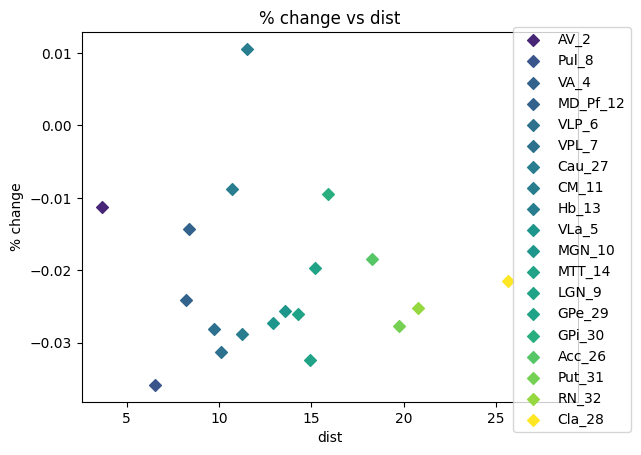

In [137]:
plot_xordered_data(adjusted_changes, "dist", "change", "struct_name", fit_line=False, ylabel="% change")

-0.4293378943493249
[0.9997229365132076, 0.9997229133386436]


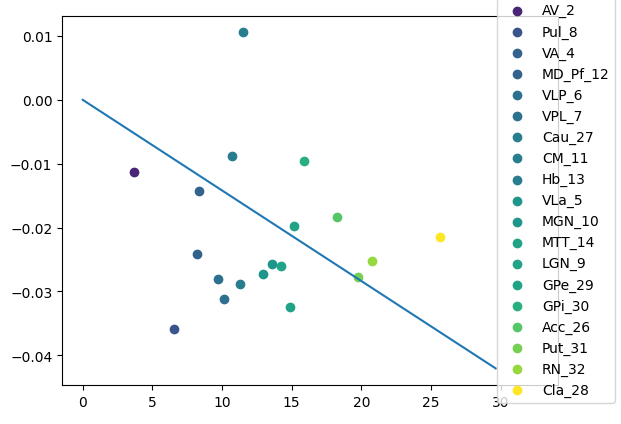

In [138]:
adjusted_changes.sort_values(by="dist", inplace=True)
popt, pcov = curve_fit(saturation_curve, adjusted_changes['dist'], adjusted_changes['change'], p0=[1, 0.01])

y_pred = saturation_curve(adjusted_changes['dist'], *popt)
ss_res = np.sum((adjusted_changes['change'] - y_pred)**2)
ss_tot = np.sum((adjusted_changes['change'] - np.mean(adjusted_changes['change']))**2)
r2 = 1 - (ss_res / ss_tot)
print(r2)

n = len(adjusted_changes['change'])
p = len(popt)
# Standard error
stderr = np.sqrt(np.diag(pcov))
# t-statistic
t_stats = popt / stderr
# two-tailed p-values assuming normality
p_vals = [2 * (1 - stats.t.cdf(np.abs(t_val), df=n - p)) for t_val in t_stats]
print(p_vals)

x = np.linspace(0, adjusted_changes['dist'].max()+4, 100)
y = saturation_curve(x, *popt)

fig, axes = plt.subplots(1)
for i, row in adjusted_changes.iterrows():
    c = row['dist'] / adjusted_changes['dist'].max()
    axes.scatter(row['dist'], row['change'], label=hips_thomas_ref[i], color=viridis(c))

axes.plot(x, y)
xlims = axes.get_xlim()
axes.set_xbound([xlims[0], xlims[1]+3])
fig.legend(loc=(0.8,0.05))

In [139]:
covariates = ["age", "Female", "t_delta"]
outcome = "change"
formula = f"{outcome} ~ {" + ".join(covariates)}"
res = sm.OLS.from_formula(formula, data=model_data).fit()

In [140]:
model_data = df_clinical.copy()
model_data = model_data.loc[model_data.index.isin(all_subids)]
model_data = model_data.join([choroid_changes])
model_data
for subject in subjects:
    subid = int(subject)
    data_struct = data_structs[subject]
    model_data.loc[subid, 't_delta'] = data_struct['t_delta']
    data = data_struct['data']
    for i, row in data.iterrows():
        model_data.loc[subid, f"change_{i}"] = row['change']
        model_data.loc[subid, f"choroid_dist_{i}"] = row['choroid_dist']
        model_data.loc[subid, f"ventricle_dist_{i}"] = row['ventricle_dist']

# numeric_cols = model_data.select_dtypes(include='number').columns
# model_data[numeric_cols] = model_data[numeric_cols].apply(stats.zscore, nan_policy="omit")

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'coef vs dist'}, xlabel='dist', ylabel='coef'>)

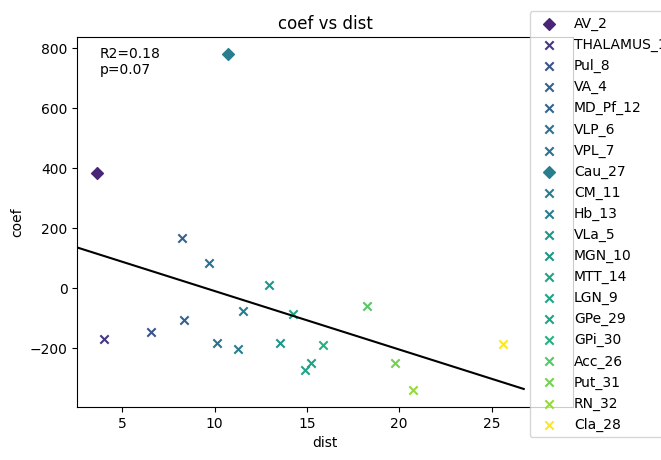

In [141]:
pvals = {}
coefs = {}
se = {}
all_results = {}
covariates = "age + Female"

for i in data_eg.index:
    predictor = f"change_{i}"
    formula = f"norm_change ~ {predictor} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[i] = res.pvalues[predictor]
    coefs[i] = res.params[predictor]
    se[i] = res.HC0_se[predictor]
    all_results[i] = res

regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals, "se": se})
regression_results['p_fdr'] = stats.false_discovery_control(
    regression_results['pvals'], method='bh'
)
regression_results['struct_name'] = hips_thomas_ref

for i, row in regression_results.iterrows():
    if row['p_fdr'] < 0.05:
        regression_results.loc[i, 'coef_sig'] = row['coef']
    else:
        regression_results.loc[i, 'coef_sig'] = 0

for i in data_eg.index:
    regression_results.loc[i, 'dist'] = model_data[f"choroid_dist_{i}"].mean()

plot_xordered_data(regression_results, "dist", "coef", "struct_name", fit_line=True, fdr=True)

In [142]:
formula = "norm_change ~ change_2 + age + Female"
res = sm.OLS.from_formula(formula, data=model_data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            norm_change   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     12.79
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           8.33e-07
Time:                        09:47:14   Log-Likelihood:                -387.18
No. Observations:                  77   AIC:                             782.4
Df Residuals:                      73   BIC:                             791.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1403     24.214     -0.006      0.9

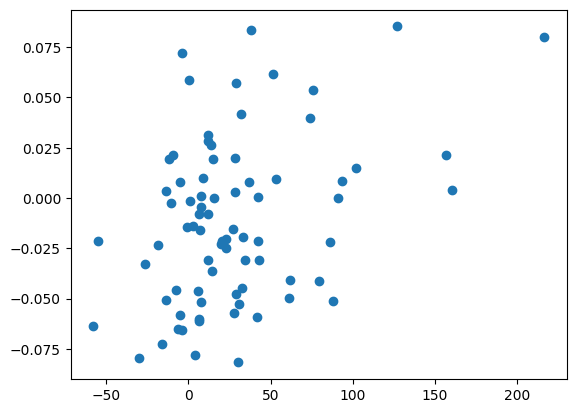

In [143]:
plt.scatter(model_data['norm_change'], model_data['change_2'])

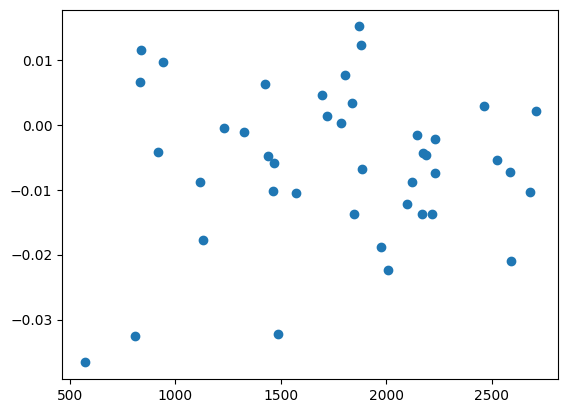

In [63]:
plt.scatter(model_data['choroid_volume'], model_data['change_12'])

In [133]:
t_stats = []
data_struct = data_structs['1119']
for subid, data_struct in data_structs.items():
    data = data_struct['data']
    data = data.loc[~data.index.isin([28]), :]
    slope, intercept, r_value, p_value, std_err = stats.linregress(data['dist'], data['change'])
    t_stats.append(slope/std_err)
int_subids = [int(subid) for subid in data_structs.keys()]
t_stats = pd.DataFrame({"t_stat": t_stats}, index=int_subids)
t_stats =t_stats.join([df_clinical])

In [ ]:
image_dir = Path("/home/srs-9/Projects/ms_mri/choroid_thalamus_project/images")
for subid in all_subjects:
    data_struct = data_structs[subid]
    data = data_struct['data']
    data = data.join([hips_thomas_ref])
    data = data.loc[~data.index.isin([28])]
    plot_data(data, "ventricle_dist", "change", "struct_name")
    plt.savefig(image_dir / f"ventricle_dist-sub{subid}.jpg", dpi=300)

In [55]:
data

,choroid_dist,ventricle_dist,change,struct_name
struct,,,,
2,2.993327,3.487120,-0.046382,AV_2
8,6.645300,7.155417,-0.073931,Pul_8
12,7.375636,7.959900,-0.020207,MD_Pf_12
4,8.000010,6.499237,0.006372,VA_4
6,9.600016,9.191304,-0.017362,VLP_6
11,10.762899,12.000001,-0.077451,CM_11
7,10.881180,11.454257,0.013263,VPL_7
13,11.113963,10.998184,0.028461,Hb_13
27,11.648190,5.425880,-0.031245,Cau_27


In [45]:
data['choroid_dist']

struct
11    10.762899
8      6.645300
5     12.315848
10    13.338673
2      2.993327
29    15.533213
30    15.615393
27    11.648190
26    19.431938
28    26.880541
9     15.030640
12     7.375636
6      9.600016
31    20.983849
14    13.047606
32    19.266556
4      8.000010
7     10.881180
13    11.113963
Name: choroid_dist, dtype: float64

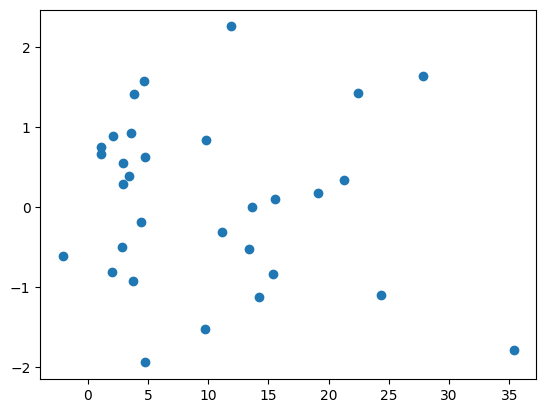

In [136]:
plt.scatter(t_stats.dzdur, t_stats.t_stat)

In [61]:
for sub in sorted(all_subjects):
    print(sub)

1003
1023
1042
1065
1071
1076
1094
1107
1119
1125
1131
1152
1155
1161
1165
1167
1198
1218
1225
1235
1240
1241
1248
1257
1301
1318
1326
1358
1360
1376
1382
1417
1442
1479
1508
1527
2006
2025
2039
2048
2075
2088
2106
2112
2113
2152
2178
2195
2213


In [65]:
all_subids = [int(sub) for sub in all_subjects]
check = df_clinical.loc[all_subids, :]
sum(check['dz_type5'] == "PMS")

25

In [67]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
with open(dataroot / "subject-sessions-longit.json", 'r') as f:
    subject_sessions = json.load(f)

date_format = "%Y%m%d"
deltas = []
for k, v in subject_sessions.items():
    sessions = sorted(v)
    time1 = datetime.strptime(str(sessions[0]), date_format)
    time2 = datetime.strptime(str(sessions[-1]), date_format)
    delta = (time2 - time1).days
    deltas.append((time2 - time1).days)
    df_clinical.loc[int(k), 'delta'] = delta / 365

deltas.sort(reverse=True)
deltas = np.array(deltas)

In [85]:
check = df_clinical.loc[df_clinical['delta'] > 5, :]
rms_check = check[check['dz_type5'] == "RMS"].index
check_inds =rms_check[~rms_check.isin(all_subids)]
check2 = df_clinical.loc[check_inds, ['dzdur']]
rms_subjects_delta5 = check2.index.tolist()

In [ ]:
check = df_clinical.loc[df_clinical['delta'] > 3, :]
pms_check = check[check['dz_type5'] == "PMS"].index
pms_subejcts_delta3 = pms_check[~pms_check.isin(all_subids)].tolist()

[1182, 1196, 1341, 1441, 1546, 2119]

In [96]:
check = df_clinical.loc[(df_clinical['delta'] > 4), :]
check = check.loc[check['dz_type5'] == "RMS", :]
check = check.loc[~check.index.isin(rms_subjects_delta5+all_subids)]
check.sort_values(by="dzdur", inplace=True)
rms_delta4_lowdzdur = list(check.index)[:10]
for subid in rms_delta4_lowdzdur:
    print(subid)

1098
2003
1211
1536
2043
2033
1364
1401
1529
2118


In [99]:
check = df_clinical.loc[df_clinical['delta'] > 2.5, :]
check = check.loc[check['dz_type5'] == "NIND"]
for subid in check.index:
    print(subid)

1027
1029
1064
1101
1105
1285
1344
1383
1423
1463
1476
2005


In [101]:
check = df_clinical.loc[df_clinical['delta'] > 2, :]
check = check.loc[check['dz_type5'] == "OIND"]
for subid in check.index:
    print(subid)

1163
1200
1264
1384
1494
2015
2078
2084
2109


In [1]:
all_subids

NameError: name 'all_subids' is not defined